# **Fairness Metrics and Bias Analysis**

Import Statements

In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
% matplotlib inline

## Load the data containing the ADS predictions into a dataframe

In [0]:
path = "./data/oof_model2_04.csv"
df = pd.read_csv(path)

In [0]:
df.columns

Index(['Unnamed: 0', 'SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE',
       'CODE_GENDER', 'FLAG_OWN_CAR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'PAYMENT_MIN_TO_ANNUITY_RATIO', 'PAYMENT_MAX_TO_ANNUITY_RATIO',
       'PAYMENT_MEAN_TO_ANNUITY_RATIO', 'CTA_CREDIT_TO_ANNUITY_MAX_RATIO',
       'CTA_CREDIT_TO_ANNUITY_MEAN_RATIO', 'DAYS_DECISION_MEAN_TO_BIRTH',
       'DAYS_CREDIT_MEAN_TO_BIRTH', 'DAYS_DECISION_MEAN_TO_EMPLOYED',
       'DAYS_CREDIT_MEAN_TO_EMPLOYED', 'PREDICTIONS'],
      dtype='object', length=661)

### ADS Predictions column, 'PREDICTIONS', is probability score. Creating a new column called 'PREDICTED_TARGET' (value 0 or 1) with threshold 0.5

In [0]:
df['PREDICTED_TARGET'] = np.where(df.PREDICTIONS > 0.5, 1, 0)
print(df['PREDICTED_TARGET'].value_counts())
print()
print(df['TARGET'].value_counts())
print()
print("Is PREDICTED_TARGET = TARGET?")
print((df['PREDICTED_TARGET']==df['TARGET']).value_counts())

0    305205
1      2301
Name: PREDICTED_TARGET, dtype: int64

0.0    282682
1.0     24824
Name: TARGET, dtype: int64

Is PREDICTED_TARGET = TARGET?
True     283047
False     24459
dtype: int64


## Metric 1: Statistical Parity

In [0]:
# Statistical Parity Function for risks. Are all subgroups assigned the same ratio of risk?

def get_ratio_of_risk_labels(df, attribute):
  """
  This function takes a dataframe and attribute and
  calculates the ratio of high-risk TARGET assignments (1)
  to the attribute
  """
  a = df.loc[df['PREDICTED_TARGET']==1, attribute].value_counts()
  b = df.loc[df['PREDICTED_TARGET']==0, attribute].value_counts()
  return a.divide(a.add(b))

(i) CODE_GENDER

Text(0, 0.5, 'GENDER')

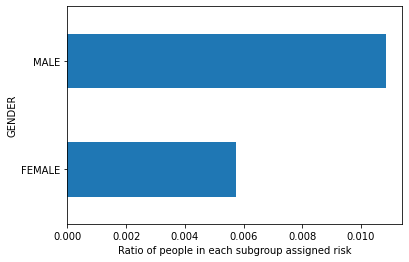

In [0]:
label_dict = {1:'FEMALE', 0:'MALE'}
get_ratio_of_risk_labels(df, 'CODE_GENDER').rename(index=label_dict).plot(kind='barh')
plt.xlabel('Ratio of people in each subgroup assigned risk')
plt.ylabel('GENDER')

(ii) AGE_RANGE

Text(0, 0.5, 'AGE_RANGE (age increasing from group 1 to 5)')

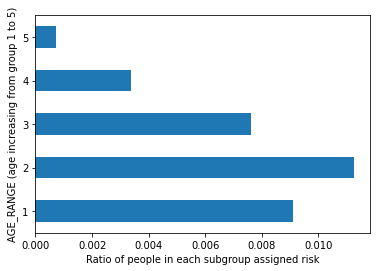

In [0]:
get_ratio_of_risk_labels(df, 'AGE_RANGE').plot(kind='barh')
plt.xlabel('Ratio of people in each subgroup assigned risk')
plt.ylabel('AGE_RANGE (age increasing from group 1 to 5)')

(iii) EMPLYOMENT DURATION

Text(0, 0.5, 'YEARS OF EMPLOYMENT BINS')

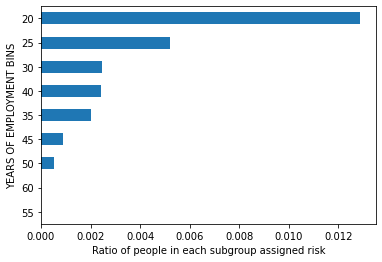

In [0]:
# Binning duration of employment for analysis --> also detect non-negative values for removal

df['DAYS_EMPLOYED_POS'] = df['DAYS_EMPLOYED']
df.DAYS_EMPLOYED_POS = np.where(df.DAYS_EMPLOYED_POS > 0, 0, df.DAYS_EMPLOYED_POS)
df['DAYS_EMPLOYED_POS'] = df['DAYS_EMPLOYED_POS'].abs()
bin_list = np.arange(df['DAYS_EMPLOYED_POS'].min(), df['DAYS_EMPLOYED_POS'].max()+10, 1825)
df['EMPLOYMENT_DURATION_BIN'] = pd.cut(x=df['DAYS_EMPLOYED_POS'], bins=bin_list, labels=np.arange(20, 65, 5))

get_ratio_of_risk_labels(df, 'EMPLOYMENT_DURATION_BIN').sort_values().plot(kind='barh')
plt.xlabel('Ratio of people in each subgroup assigned risk')
plt.ylabel('YEARS OF EMPLOYMENT BINS')

(iv) OCCUPATION_TYPE

Text(0, 0.5, 'OCCUPATION TYPE')

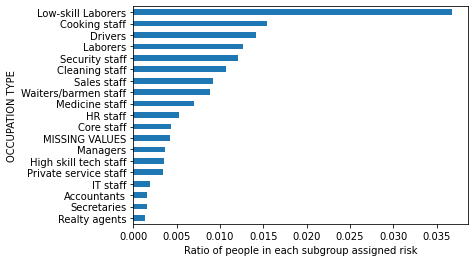

In [0]:
label_dict = {-1: 'MISSING VALUES', 0: 'Laborers', 5: 'Sales staff', 1: 'Core staff', 3: 'Managers', 4: 'Drivers', 11: 'High skill tech staff', 2: 'Accountants', 9: 'Medicine staff', \
 10: 'Security staff', 7: 'Cooking staff', 6: 'Cleaning staff', 8: 'Private service staff', 13: 'Low-skill Laborers', 12: 'Waiters/barmen staff', 15: 'Secretaries', \
 14: 'Realty agents', 17: 'HR staff', 16: 'IT staff'}
get_ratio_of_risk_labels(df, 'OCCUPATION_TYPE').rename(index=label_dict).sort_values().plot(kind='barh')
plt.xlabel('Ratio of people in each subgroup assigned risk')
plt.ylabel('OCCUPATION TYPE')

(v) RATING OF REGION WHERE THE CLIENT LIVES

Text(0, 0.5, 'RATING OF REGION best(1) to worst(3)')

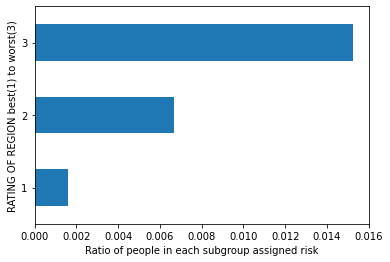

In [0]:
get_ratio_of_risk_labels(df, 'REGION_RATING_CLIENT').sort_values('index').plot(kind='barh')
plt.xlabel('Ratio of people in each subgroup assigned risk')
plt.ylabel('RATING OF REGION best(1) to worst(3)')

Text(0, 0.5, 'RATING OF REGION WRT CITY best(1) to worst(3)')

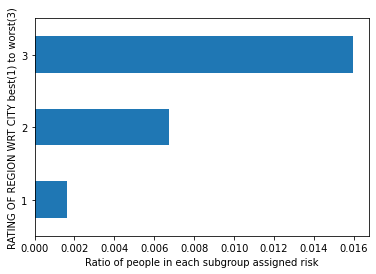

In [0]:
get_ratio_of_risk_labels(df, 'REGION_RATING_CLIENT_W_CITY').sort_values('index').plot(kind='barh')
plt.xlabel('Ratio of people in each subgroup assigned risk')
plt.ylabel('RATING OF REGION WRT CITY best(1) to worst(3)')

## Metric 2: Disparate Impact

In [0]:
# Disparate Impact function: gives ratio of fraction of protected group assigned no-risk to fraction of privileged group assigned no risk.

def get_disparate_impact(df, attribute, prot, priv):
  """
  This function takes a dataframe and attribute and
  calculates disparate impact. prot and priv are labels
  for protected and privileged classes.
  """
  a = df.loc[df['PREDICTED_TARGET']==0, attribute].value_counts()
  b = df[attribute].value_counts()
  prob_pos = a.divide(b)
  return prob_pos[prot]/prob_pos[priv]

(i) CODE_GENDER

In [0]:
# CODE_GENDER: F or Female: 1 (protected) and M or Male: 0 (privileged)
get_disparate_impact(df, 'CODE_GENDER', 1, 0)

1.0051870031056493

(ii) AGE

In [0]:
# AGE: <=50 (protected) >50 (privileged)

# Creating age categories from days since birth (negative)
# Days for partitioning the data is 18262 (nearly 50 years with inclusion of leap days)
df['AGE_CATEGORY'] = np.where(df.DAYS_BIRTH <= -18262, '>=50', '<50')
get_disparate_impact(df, 'AGE_CATEGORY', '<50', '>=50')

0.9934844659242509

(iii) EMPLOYMENT DURATION

In [0]:
# Years of experience: <5 (protected) >=5 (privileged)

# Creating categories from days since employment (negative)
# Days for partitioning the data is 1825 (5 years)
df['EMPLOYMENT_DURATION_CATEGORY'] = np.where(df.DAYS_EMPLOYED <= -1825, '>=5', '<5')
get_disparate_impact(df, 'EMPLOYMENT_DURATION_CATEGORY', '<5', '>=5')

0.9941609050844655

(iv) OCCUPATION_TYPE

In [0]:
label_dict = {-1: 'MISSING VALUES', 0: 'Laborers', 5: 'Sales staff', 1: 'Core staff', 3: 'Managers', 4: 'Drivers', 11: 'High skill tech staff', 2: 'Accountants', 9: 'Medicine staff', \
 10: 'Security staff', 7: 'Cooking staff', 6: 'Cleaning staff', 8: 'Private service staff', 13: 'Low-skill Laborers', 12: 'Waiters/barmen staff', 15: 'Secretaries', \
 14: 'Realty agents', 17: 'HR staff', 16: 'IT staff'}

# create a new dataframe for occupation
df_occ = df[['OCCUPATION_TYPE', 'PREDICTED_TARGET']]
df_occ = df_occ[df_occ.OCCUPATION_TYPE!=-1]

# create a status column to indicated privileges or protected status of group
# (i) 13 or Low-skill Laborers as unprivileged, rest as privileged
df_occ['STATUS'] = np.where(df_occ.OCCUPATION_TYPE == 13, 'UNPRIV', 'PRIV')
print('Unprivileged group: Low-skill Laborers')
print(get_disparate_impact(df_occ, 'STATUS', 'UNPRIV', 'PRIV'))

# (ii) 7 or Cooking staff as unprivileged, rest as privileged, drop the previous occupation
df_occ = df_occ[df_occ.OCCUPATION_TYPE!=13]
df_occ['STATUS'] = np.where(df_occ.OCCUPATION_TYPE == 7, 'UNPRIV', 'PRIV')
print('Unprivileged group: Cooking staff')
print(get_disparate_impact(df_occ, 'STATUS', 'UNPRIV', 'PRIV'))

# (iii) 4 or Drivers as unprivileged, rest as privileged, drop the previous occupation
df_occ = df_occ[df_occ.OCCUPATION_TYPE!=7]
df_occ['STATUS'] = np.where(df_occ.OCCUPATION_TYPE == 4, 'UNPRIV', 'PRIV')
print('Unprivileged group: Drivers')
print(get_disparate_impact(df_occ, 'STATUS', 'UNPRIV', 'PRIV'))

# (iv) 0 or Laborers as unprivileged, rest as privileged, drop the previous occupation
df_occ = df_occ[df_occ.OCCUPATION_TYPE!=4]
df_occ['STATUS'] = np.where(df_occ.OCCUPATION_TYPE == 0, 'UNPRIV', 'PRIV')
print('Unprivileged group: Laborers')
print(get_disparate_impact(df_occ, 'STATUS', 'UNPRIV', 'PRIV'))

del df_occ

Unprivileged group: Low-skill Laborers
0.9716533925561107
Unprivileged group: Cooking staff
0.9929766556076167
Unprivileged group: Drivers
0.9936946933382675
Unprivileged group: Laborers
0.9932880964759297


(v) RATING OF REGION WHERE CLIENT LIVES

In [0]:
print('UNPRIVILEGED RATING | PRIVILEGED RATING | disparate impact')
print(3, '\t\t\t', 1, '\t\t', get_disparate_impact(df, 'REGION_RATING_CLIENT', 3, 1))
print(3, '\t\t\t', 2, '\t\t', get_disparate_impact(df, 'REGION_RATING_CLIENT', 3, 2))
print(2, '\t\t\t', 1, '\t\t', get_disparate_impact(df, 'REGION_RATING_CLIENT', 2, 1))

UNPRIVILEGED RATING | PRIVILEGED RATING | disparate impact
3 			 1 		 0.986322632990273
3 			 2 		 0.9913289164215078
2 			 1 		 0.9949499269633872


In [0]:
print('UNPRIVILEGED RATING | PRIVILEGED RATING | disparate impact')
print(3, '\t\t\t', 1, '\t\t', get_disparate_impact(df, 'REGION_RATING_CLIENT_W_CITY', 3, 1))
print(3, '\t\t\t', 2, '\t\t', get_disparate_impact(df, 'REGION_RATING_CLIENT_W_CITY', 3, 2))
print(2, '\t\t\t', 1, '\t\t', get_disparate_impact(df, 'REGION_RATING_CLIENT_W_CITY', 2, 1))

UNPRIVILEGED RATING | PRIVILEGED RATING | disparate impact
3 			 1 		 0.9856035292633775
3 			 2 		 0.9906868746473734
2 			 1 		 0.9948688677380477


## Metrics 3 and 4: Predictive Parity (equality of Positive Predictive Value); and NPV (Negative Predictive Value).

#### Here, positive is 0 or no risk label, and negative is 1 or risk label.

In [0]:
confusion_df = pd.DataFrame(data=[['true_no_risk', 'false_no_risk'], ['false_risk', 'true_risk']], \
                            columns=['actual_no_risk', 'actual_risk'], index=['predicted_no_risk', 'predicted_risk'])
confusion_df

,actual_no_risk,actual_risk
predicted_no_risk,true_no_risk,false_no_risk
predicted_risk,false_risk,true_risk


In [0]:
def get_ppv_npv(df, attribute, labels_dict=None):
  unique_attr_values = np.array(df[attribute].unique())
  unique_attr_values = np.delete(unique_attr_values, np.where(np.isnan(unique_attr_values)))
  result_df = pd.DataFrame(data=np.zeros((len(unique_attr_values), 2)), columns=['PPV', 'NPV'], index=unique_attr_values)
  for value in unique_attr_values:
    temp_df = df[[attribute, 'TARGET', 'PREDICTED_TARGET']]
    temp_df = temp_df[temp_df[attribute]==value]
    conf = confusion_matrix(temp_df['TARGET'], temp_df['PREDICTED_TARGET'])
    true_no_risk, false_no_risk, false_risk, true_risk = conf[0][0], conf[0][1], conf[1][0], conf[1][1]
    ppv = true_no_risk / (true_no_risk + false_no_risk)
    npv = true_risk / (false_risk + true_risk)
    result_df.at[value, 'PPV'] = ppv
    result_df.at[value, 'NPV'] = npv
  if labels_dict:
    result_df.rename(index=labels_dict, inplace=True)
  return result_df

(i) CODE_GENDER

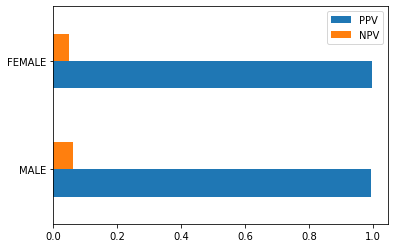

In [0]:
get_ppv_npv(df, 'CODE_GENDER', {1:'FEMALE', 0:'MALE'}).plot(kind='barh')

(ii) AGE_RANGE

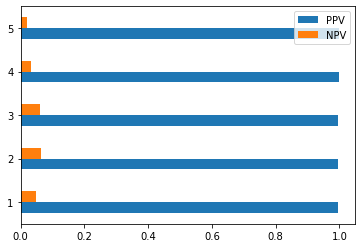

In [0]:
get_ppv_npv(df, 'AGE_RANGE').sort_index().plot(kind='barh')

(iii) EMPLOYMENT DURATION

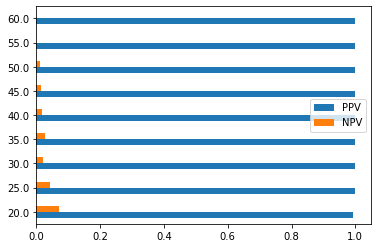

In [0]:
get_ppv_npv(df, 'EMPLOYMENT_DURATION_BIN').sort_index().plot(kind='barh')

(iv) OCCUPATION_TYPE

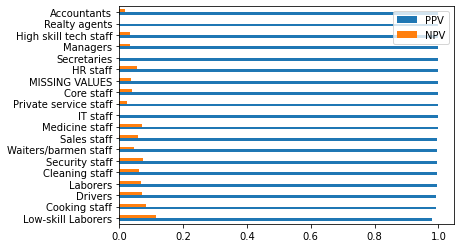

In [0]:
occu_dict = {-1: 'MISSING VALUES', 0: 'Laborers', 5: 'Sales staff', 1: 'Core staff', 3: 'Managers', 4: 'Drivers', 11: 'High skill tech staff', 2: 'Accountants', 9: 'Medicine staff', \
 10: 'Security staff', 7: 'Cooking staff', 6: 'Cleaning staff', 8: 'Private service staff', 13: 'Low-skill Laborers', 12: 'Waiters/barmen staff', 15: 'Secretaries', \
 14: 'Realty agents', 17: 'HR staff', 16: 'IT staff'}

get_ppv_npv(df, 'OCCUPATION_TYPE', occu_dict).sort_values(by='PPV').plot(kind='barh')

(v) RATING OF REGION WHERE CLIENT LIVES

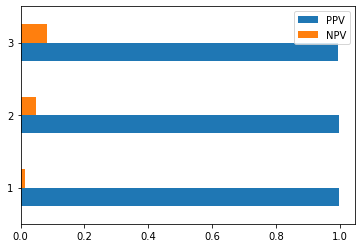

In [0]:
get_ppv_npv(df, 'REGION_RATING_CLIENT').sort_index().plot(kind='barh')

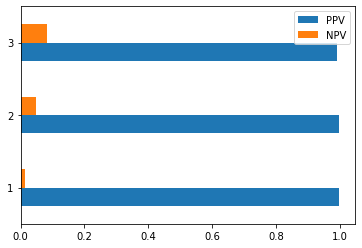

In [0]:
get_ppv_npv(df, 'REGION_RATING_CLIENT_W_CITY').sort_index().plot(kind='barh')

## Metrics 5 and 6: False Positive Rate Ratio and False Negative Rate Ratio

#### Here, positive is 0 or no risk label, and negative is 1 or risk label.

In [0]:
def get_fprr_fnrr(df, attribute, priv, unpriv):

  # for privileged group
  temp_df = df[[attribute, 'TARGET', 'PREDICTED_TARGET']]
  temp_df = temp_df[temp_df[attribute]==priv]
  conf = confusion_matrix(temp_df['TARGET'], temp_df['PREDICTED_TARGET'])
  true_no_risk, false_no_risk, false_risk, true_risk = conf[0][0], conf[0][1], conf[1][0], conf[1][1]
  fpr_priv = false_no_risk / (false_no_risk + true_risk)
  fnr_priv = false_risk / (true_no_risk + false_risk)
  # for unprivileged group
  temp_df = df[[attribute, 'TARGET', 'PREDICTED_TARGET']]
  temp_df = temp_df[temp_df[attribute]==unpriv]
  conf = confusion_matrix(temp_df['TARGET'], temp_df['PREDICTED_TARGET'])
  true_no_risk, false_no_risk, false_risk, true_risk = conf[0][0], conf[0][1], conf[1][0], conf[1][1]
  fpr_unpriv = false_no_risk / (false_no_risk + true_risk)
  fnr_unpriv = false_risk / (true_no_risk + false_risk)
  return fpr_unpriv/fpr_priv, fnr_unpriv/fnr_priv

(i) CODE_GENDER

In [0]:
# 0: MALE, 1: FEMALE
get_fprr_fnrr(df, 'CODE_GENDER', 0, 1)

(0.9635057471264369, 0.696133191072998)

(ii) AGE

In [0]:
get_fprr_fnrr(df, 'AGE_CATEGORY', '>=50', '<50')

(0.9591017193652773, 1.584739420930549)

(iii) EMPLOYMENT DURATION

In [0]:
get_fprr_fnrr(df, 'EMPLOYMENT_DURATION_CATEGORY', '>=5', '<5')

(1.034228164182008, 1.3854650411550578)

(iv) OCCUPATION_TYPE

In [0]:
label_dict = {-1: 'MISSING VALUES', 0: 'Laborers', 5: 'Sales staff', 1: 'Core staff', 3: 'Managers', 4: 'Drivers', 11: 'High skill tech staff', 2: 'Accountants', 9: 'Medicine staff', \
 10: 'Security staff', 7: 'Cooking staff', 6: 'Cleaning staff', 8: 'Private service staff', 13: 'Low-skill Laborers', 12: 'Waiters/barmen staff', 15: 'Secretaries', \
 14: 'Realty agents', 17: 'HR staff', 16: 'IT staff'}

# create a new dataframe for occupation
df_occ = df[['OCCUPATION_TYPE', 'PREDICTED_TARGET', 'TARGET']]
df_occ = df_occ[df_occ.OCCUPATION_TYPE!=-1]

# create a status column to indicated privileges or protected status of group
# (i) 13 or Low-skill Laborers as unprivileged, rest as privileged
df_occ['STATUS'] = np.where(df_occ.OCCUPATION_TYPE == 13, 'UNPRIV', 'PRIV')
print('Unprivileged group: Low-skill Laborers')
print(get_fprr_fnrr(df_occ, 'STATUS', 'PRIV', 'UNPRIV'))

# (ii) 7 or Cooking staff as unprivileged, rest as privileged, drop the previous occupation
df_occ = df_occ[df_occ.OCCUPATION_TYPE!=13]
df_occ['STATUS'] = np.where(df_occ.OCCUPATION_TYPE == 7, 'UNPRIV', 'PRIV')
print('Unprivileged group: Cooking staff')
print(get_fprr_fnrr(df_occ, 'STATUS', 'PRIV', 'UNPRIV'))

# (iii) 4 or Drivers as unprivileged, rest as privileged, drop the previous occupation
df_occ = df_occ[df_occ.OCCUPATION_TYPE!=7]
df_occ['STATUS'] = np.where(df_occ.OCCUPATION_TYPE == 4, 'UNPRIV', 'PRIV')
print('Unprivileged group: Drivers')
print(get_fprr_fnrr(df_occ, 'STATUS', 'PRIV', 'UNPRIV'))

# (iv) 0 or Laborers as unprivileged, rest as privileged, drop the previous occupation
df_occ = df_occ[df_occ.OCCUPATION_TYPE!=4]
df_occ['STATUS'] = np.where(df_occ.OCCUPATION_TYPE == 0, 'UNPRIV', 'PRIV')
print('Unprivileged group: Laborers')
print(get_fprr_fnrr(df_occ, 'STATUS', 'PRIV', 'UNPRIV'))

del df_occ

Unprivileged group: Low-skill Laborers
(1.1181459801696332, 1.9091745931668487)
Unprivileged group: Cooking staff
(1.0420309955979015, 1.1818959188348532)
Unprivileged group: Drivers
(1.030651913875598, 1.3366899471266003)
Unprivileged group: Laborers
(1.0468611847922191, 1.3991088276912098)


(v) RATING OF REGION WHERE CLIENT LIVES

In [0]:
print('UNPRIVILEGED RATING | PRIVILEGED RATING | (FPR Ratio, FNR Ratio)')
print(3, '\t\t\t', 1, '\t\t', get_fprr_fnrr(df, 'REGION_RATING_CLIENT', 1, 3))
print(3, '\t\t\t', 2, '\t\t', get_fprr_fnrr(df, 'REGION_RATING_CLIENT', 2, 3))
print(2, '\t\t\t', 1, '\t\t', get_fprr_fnrr(df, 'REGION_RATING_CLIENT', 1, 2))

UNPRIVILEGED RATING | PRIVILEGED RATING | (FPR Ratio, FNR Ratio)
3 			 1 		 (0.6841507124748667, 2.1745641657789476)
3 			 2 		 (0.9689859555828263, 1.371136453871947)
2 			 1 		 (0.7060481202365448, 1.5859575169474955)


In [0]:
print('UNPRIVILEGED RATING | PRIVILEGED RATING | (FPR Ratio, FNR Ratio)')
print(3, '\t\t\t', 1, '\t\t', get_fprr_fnrr(df, 'REGION_RATING_CLIENT_W_CITY', 1, 3))
print(3, '\t\t\t', 2, '\t\t', get_fprr_fnrr(df, 'REGION_RATING_CLIENT_W_CITY', 2, 3))
print(2, '\t\t\t', 1, '\t\t', get_fprr_fnrr(df, 'REGION_RATING_CLIENT_W_CITY', 1, 2))

UNPRIVILEGED RATING | PRIVILEGED RATING | (FPR Ratio, FNR Ratio)
3 			 1 		 (0.691422967189729, 2.2204806663516816)
3 			 2 		 (0.9503461634100694, 1.4005909694252707)
2 			 1 		 (0.7275485436893204, 1.5853883930601458)


## EQUALITY OF PROBABILTY OF RISK OUTCOMES BASED ON CONDITIONS

1. given CREDIT_TO_INCOME_RATIO
2. given ANNUITY_TO_INCOME_RATIO
3. given CREDIT_TO_ANNUITY_RATIO


In [0]:
# Another function for no-risk cases

def get_ratio_of_no_risk_labels(df, attribute):
  """
  This function takes a dataframe and attribute and
  calculates the ratio of no-risk TARGET assignments (0)
  to the attribute
  """
  a = df.loc[df['PREDICTED_TARGET']==0, attribute].value_counts()
  b = df.loc[df['PREDICTED_TARGET']==1, attribute].value_counts()
  return a.divide(a.add(b))

**1. given CREDIT_TO_INCOME_RATIO**



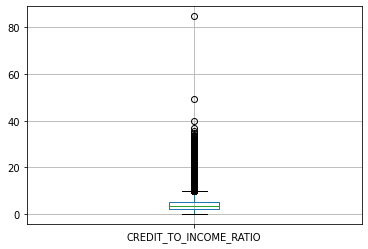

In [0]:
df[['CREDIT_TO_INCOME_RATIO']].boxplot()

In [0]:
# bin CREDIT_TO_INCOME_RATIO
s = df[df['CREDIT_TO_INCOME_RATIO']<=40]['CREDIT_TO_INCOME_RATIO'] # drop the most outlying cases
labels = [str(i)+"-"+str(i+4) for i in range(0, 40, 4)]
df['BINNED_CTIR'] = pd.cut(s, bins=10, labels=labels)

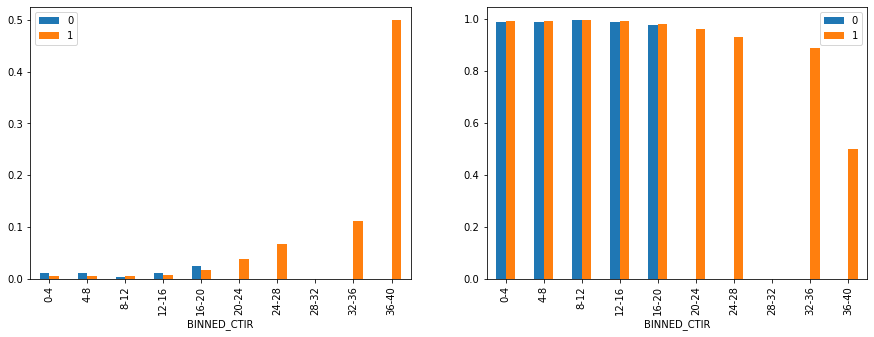

In [0]:
# CODE_GENDER
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['CODE_GENDER', 'BINNED_CTIR', 'PREDICTED_TARGET']].groupby('BINNED_CTIR').apply(lambda x: get_ratio_of_risk_labels(x, 'CODE_GENDER')).unstack(1).plot(kind='bar', ax=ax1)
df[['CODE_GENDER', 'BINNED_CTIR', 'PREDICTED_TARGET']].groupby('BINNED_CTIR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'CODE_GENDER')).unstack(1).plot(kind='bar', ax=ax2)

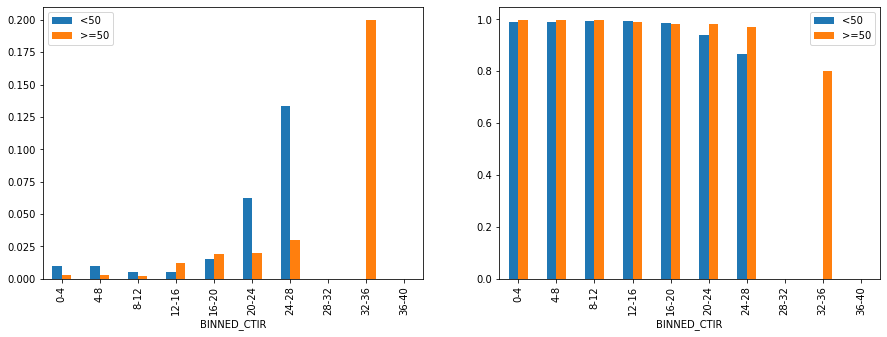

In [0]:
# AGE
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['AGE_CATEGORY', 'BINNED_CTIR', 'PREDICTED_TARGET']].groupby('BINNED_CTIR').apply(lambda x: get_ratio_of_risk_labels(x, 'AGE_CATEGORY')).unstack(1).plot(kind='bar', ax=ax1)
df[['AGE_CATEGORY', 'BINNED_CTIR', 'PREDICTED_TARGET']].groupby('BINNED_CTIR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'AGE_CATEGORY')).unstack(1).plot(kind='bar', ax=ax2)

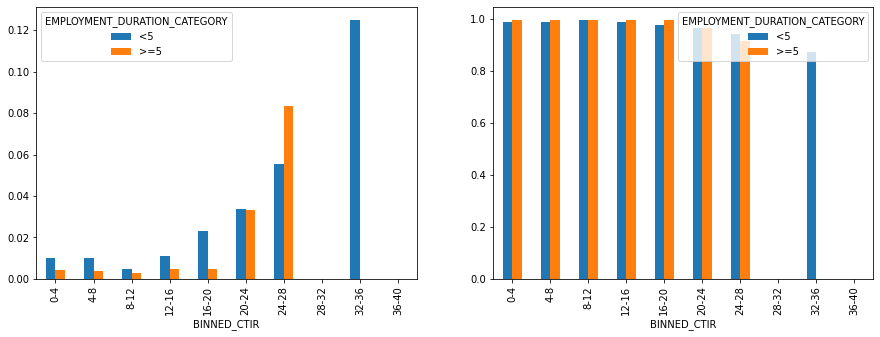

In [0]:
# EMPLOYMENT DURATION
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['EMPLOYMENT_DURATION_CATEGORY', 'BINNED_CTIR', 'PREDICTED_TARGET']].groupby('BINNED_CTIR').apply(lambda x: get_ratio_of_risk_labels(x, 'EMPLOYMENT_DURATION_CATEGORY')).plot(kind='bar', ax=ax1)
df[['EMPLOYMENT_DURATION_CATEGORY', 'BINNED_CTIR', 'PREDICTED_TARGET']].groupby('BINNED_CTIR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'EMPLOYMENT_DURATION_CATEGORY')).plot(kind='bar', ax=ax2)

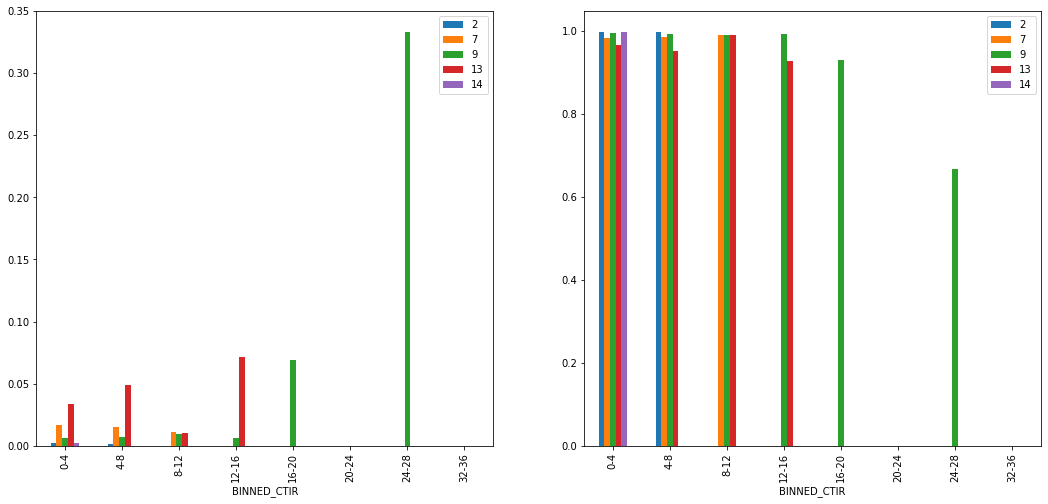

In [0]:
# OCCUPATION_TYPE
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
occ_df = df[(df['OCCUPATION_TYPE']==13)|(df['OCCUPATION_TYPE']==7)|(df['OCCUPATION_TYPE']==9)|(df['OCCUPATION_TYPE']==14)|(df['OCCUPATION_TYPE']==2)][['OCCUPATION_TYPE', 'BINNED_CTIR', 'PREDICTED_TARGET']]
occ_df.groupby('BINNED_CTIR').apply(lambda x: get_ratio_of_risk_labels(x, 'OCCUPATION_TYPE')).unstack(1).plot(kind='bar', figsize=(18,8), ax=ax1)
occ_df.groupby('BINNED_CTIR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'OCCUPATION_TYPE')).unstack(1).plot(kind='bar', figsize=(18,8), ax=ax2)

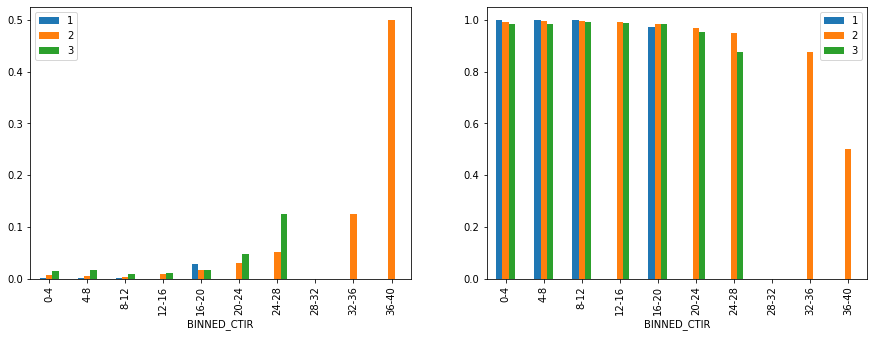

In [0]:
# RATING OF REGION WHERE CLIENT LIVES
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['REGION_RATING_CLIENT', 'BINNED_CTIR', 'PREDICTED_TARGET']].groupby('BINNED_CTIR').apply(lambda x: get_ratio_of_risk_labels(x, 'REGION_RATING_CLIENT')).unstack(1).plot(kind='bar', ax=ax1)
df[['REGION_RATING_CLIENT', 'BINNED_CTIR', 'PREDICTED_TARGET']].groupby('BINNED_CTIR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'REGION_RATING_CLIENT')).unstack(1).plot(kind='bar', ax=ax2)

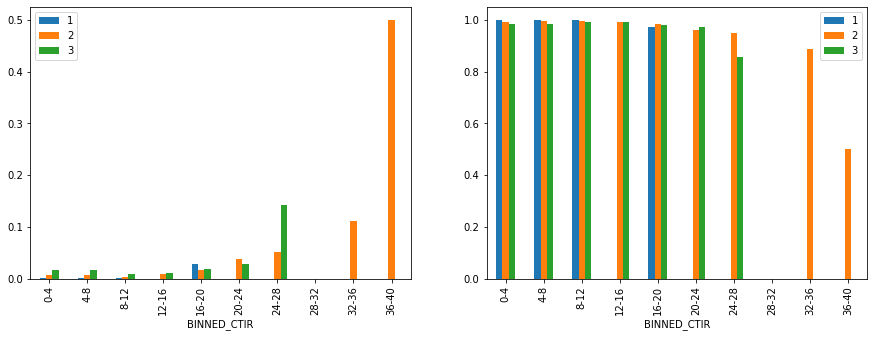

In [0]:
# RATING OF REGION WHERE CLIENT LIVES WITH RESPECT TO CITY
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['REGION_RATING_CLIENT_W_CITY', 'BINNED_CTIR', 'PREDICTED_TARGET']].groupby('BINNED_CTIR').apply(lambda x: get_ratio_of_risk_labels(x, 'REGION_RATING_CLIENT_W_CITY')).unstack(1).plot(kind='bar', ax=ax1)
df[['REGION_RATING_CLIENT_W_CITY', 'BINNED_CTIR', 'PREDICTED_TARGET']].groupby('BINNED_CTIR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'REGION_RATING_CLIENT_W_CITY')).unstack(1).plot(kind='bar', ax=ax2)

**1. given ANNUITY_TO_INCOME_RATIO**

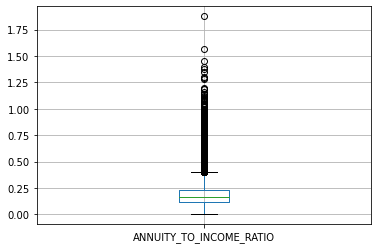

In [0]:
df[['ANNUITY_TO_INCOME_RATIO']].boxplot()

In [0]:
# bin ANNUITY_TO_INCOME_RATIO
s = df[df['ANNUITY_TO_INCOME_RATIO']<=1]['ANNUITY_TO_INCOME_RATIO'] # drop the most outlying cases
labels = [str(round(i, 1))+"-"+str(round(i+0.1, 1)) for i in np.arange(0, 1, 0.1)]
df['BINNED_ATIR'] = pd.cut(s, bins=10, labels=labels)

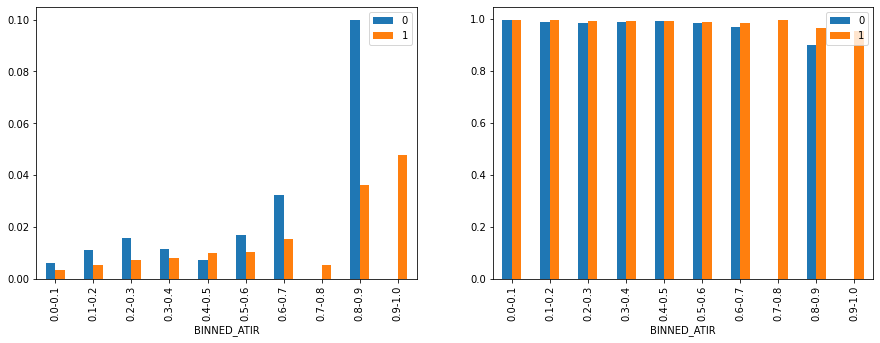

In [0]:
# CODE_GENDER
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['CODE_GENDER', 'BINNED_ATIR', 'PREDICTED_TARGET']].groupby('BINNED_ATIR').apply(lambda x: get_ratio_of_risk_labels(x, 'CODE_GENDER')).unstack(1).plot(kind='bar', ax=ax1)
df[['CODE_GENDER', 'BINNED_ATIR', 'PREDICTED_TARGET']].groupby('BINNED_ATIR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'CODE_GENDER')).unstack(1).plot(kind='bar', ax=ax2)

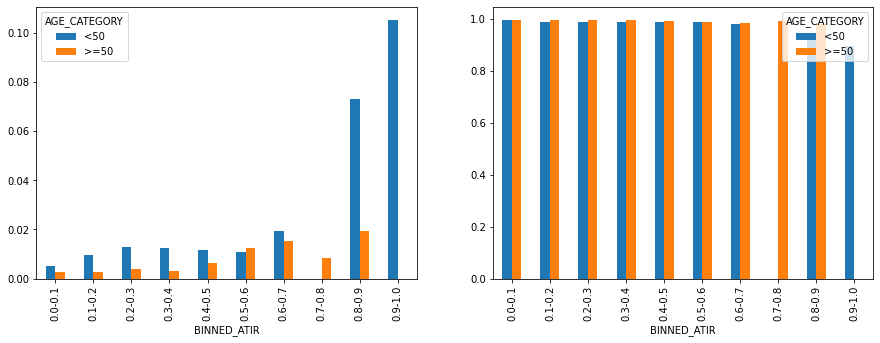

In [0]:
# AGE
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['AGE_CATEGORY', 'BINNED_ATIR', 'PREDICTED_TARGET']].groupby('BINNED_ATIR').apply(lambda x: get_ratio_of_risk_labels(x, 'AGE_CATEGORY')).plot(kind='bar', ax=ax1)
df[['AGE_CATEGORY', 'BINNED_ATIR', 'PREDICTED_TARGET']].groupby('BINNED_ATIR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'AGE_CATEGORY')).plot(kind='bar', ax=ax2)

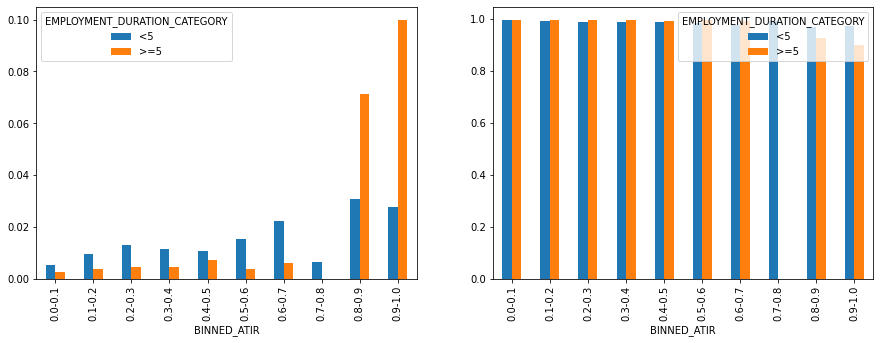

In [0]:
# EMPLOYMENT DURATION
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['EMPLOYMENT_DURATION_CATEGORY', 'BINNED_ATIR', 'PREDICTED_TARGET']].groupby('BINNED_ATIR').apply(lambda x: get_ratio_of_risk_labels(x, 'EMPLOYMENT_DURATION_CATEGORY')).plot(kind='bar', ax=ax1)
df[['EMPLOYMENT_DURATION_CATEGORY', 'BINNED_ATIR', 'PREDICTED_TARGET']].groupby('BINNED_ATIR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'EMPLOYMENT_DURATION_CATEGORY')).plot(kind='bar', ax=ax2)

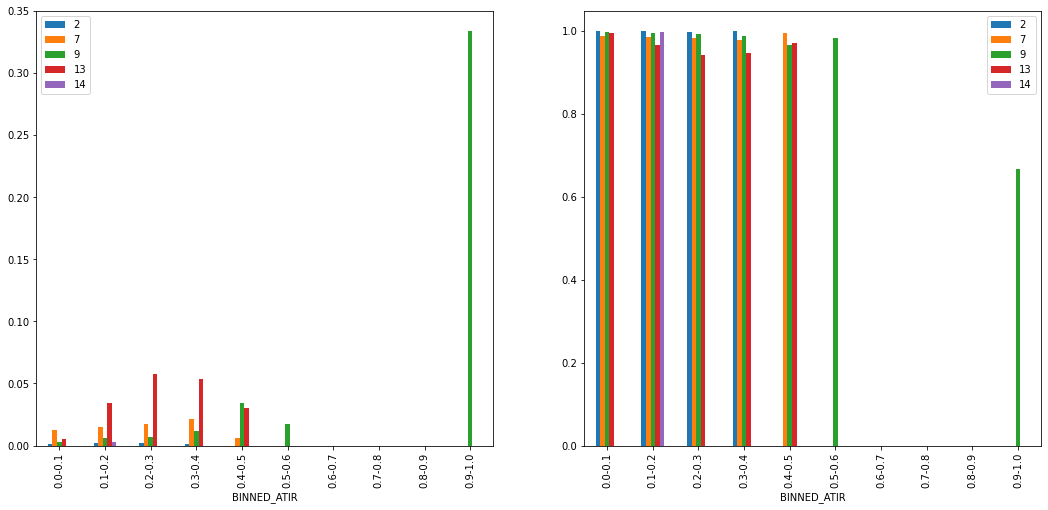

In [0]:
# OCCUPATION_TYPE
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
occ_df = df[(df['OCCUPATION_TYPE']==13)|(df['OCCUPATION_TYPE']==7)|(df['OCCUPATION_TYPE']==9)|(df['OCCUPATION_TYPE']==14)|(df['OCCUPATION_TYPE']==2)][['OCCUPATION_TYPE', 'BINNED_ATIR', 'PREDICTED_TARGET']]
occ_df.groupby('BINNED_ATIR').apply(lambda x: get_ratio_of_risk_labels(x, 'OCCUPATION_TYPE')).unstack(1).plot(kind='bar', figsize=(18,8), ax=ax1)
occ_df.groupby('BINNED_ATIR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'OCCUPATION_TYPE')).unstack(1).plot(kind='bar', figsize=(18,8), ax=ax2)

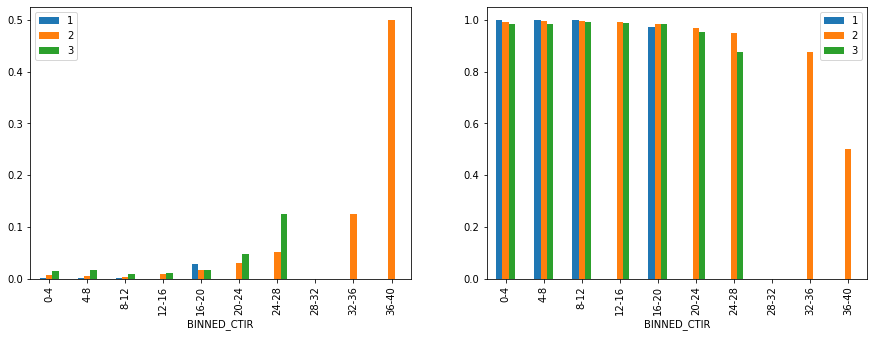

In [0]:
# RATING OF REGION WHERE CLIENT LIVES
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['REGION_RATING_CLIENT', 'BINNED_ATIR', 'PREDICTED_TARGET']].groupby('BINNED_ATIR').apply(lambda x: get_ratio_of_risk_labels(x, 'REGION_RATING_CLIENT')).unstack(1).plot(kind='bar', ax=ax1)
df[['REGION_RATING_CLIENT', 'BINNED_ATIR', 'PREDICTED_TARGET']].groupby('BINNED_ATIR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'REGION_RATING_CLIENT')).unstack(1).plot(kind='bar', ax=ax2)

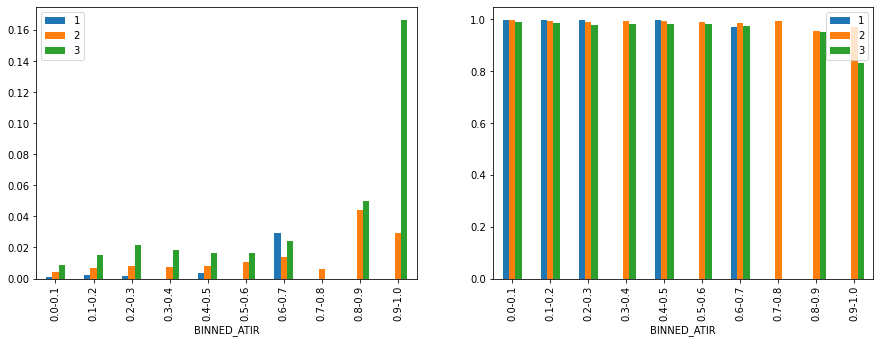

In [0]:
# RATING OF REGION WHERE CLIENT LIVES WITH RESPECT TO CITY
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['REGION_RATING_CLIENT_W_CITY', 'BINNED_ATIR', 'PREDICTED_TARGET']].groupby('BINNED_ATIR').apply(lambda x: get_ratio_of_risk_labels(x, 'REGION_RATING_CLIENT_W_CITY')).unstack(1).plot(kind='bar', ax=ax1)
df[['REGION_RATING_CLIENT_W_CITY', 'BINNED_ATIR', 'PREDICTED_TARGET']].groupby('BINNED_ATIR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'REGION_RATING_CLIENT_W_CITY')).unstack(1).plot(kind='bar', ax=ax2)

**3. given CREDIT_TO_ANNUITY_RATIO**



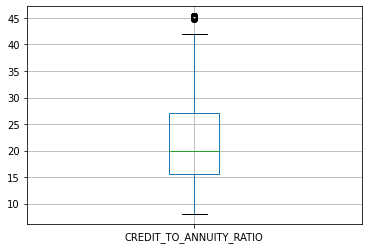

In [0]:
df[['CREDIT_TO_ANNUITY_RATIO']].boxplot()

In [0]:
# bin ANNUITY_TO_INCOME_RATIO
s = df[df['CREDIT_TO_ANNUITY_RATIO']<=40]['CREDIT_TO_ANNUITY_RATIO'] # drop the most outlying cases
labels = [str(i)+"-"+str(i+4) for i in np.arange(8, 40, 4)]
df['BINNED_CTAR'] = pd.cut(s, bins=8, labels=labels)

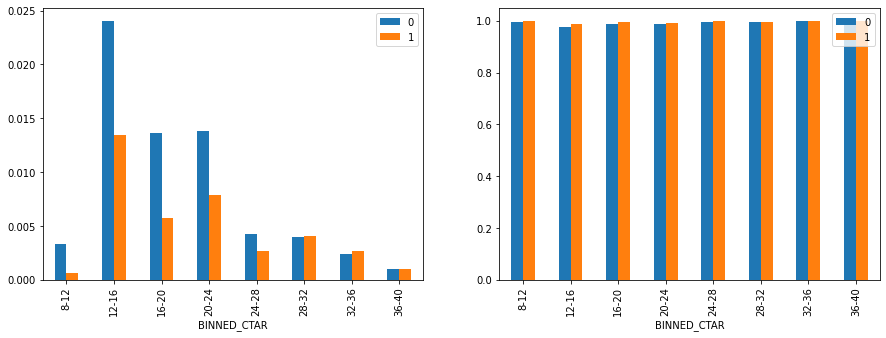

In [0]:
# CODE_GENDER
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['CODE_GENDER', 'BINNED_CTAR', 'PREDICTED_TARGET']].groupby('BINNED_CTAR').apply(lambda x: get_ratio_of_risk_labels(x, 'CODE_GENDER')).unstack(1).plot(kind='bar', ax=ax1)
df[['CODE_GENDER', 'BINNED_CTAR', 'PREDICTED_TARGET']].groupby('BINNED_CTAR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'CODE_GENDER')).unstack(1).plot(kind='bar', ax=ax2)

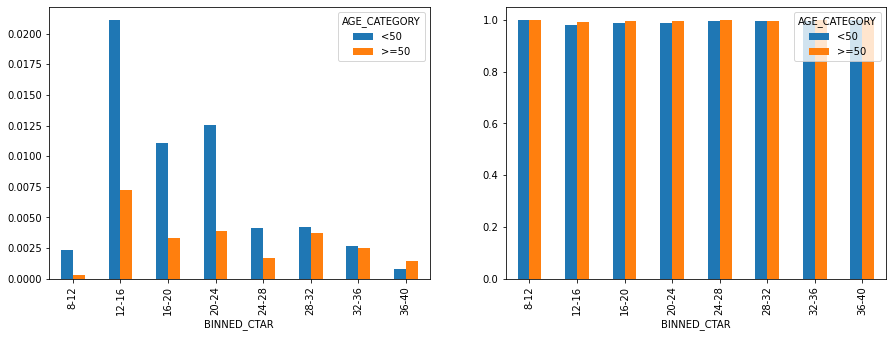

In [0]:
# AGE
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['AGE_CATEGORY', 'BINNED_CTAR', 'PREDICTED_TARGET']].groupby('BINNED_CTAR').apply(lambda x: get_ratio_of_risk_labels(x, 'AGE_CATEGORY')).plot(kind='bar', ax=ax1)
df[['AGE_CATEGORY', 'BINNED_CTAR', 'PREDICTED_TARGET']].groupby('BINNED_CTAR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'AGE_CATEGORY')).plot(kind='bar', ax=ax2)

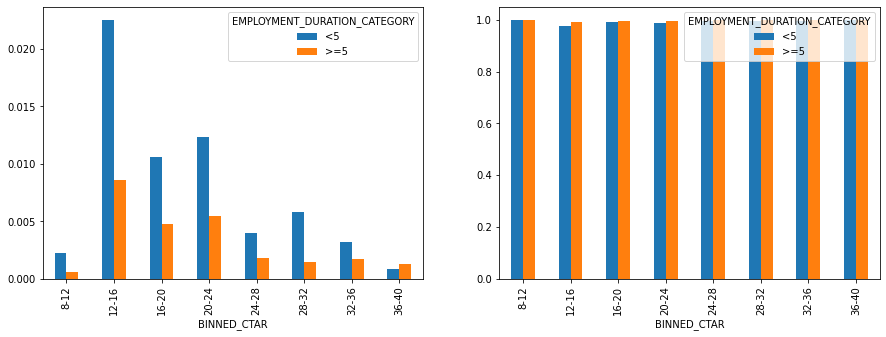

In [0]:
# EMPLOYMENT DURATION
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['EMPLOYMENT_DURATION_CATEGORY', 'BINNED_CTAR', 'PREDICTED_TARGET']].groupby('BINNED_CTAR').apply(lambda x: get_ratio_of_risk_labels(x, 'EMPLOYMENT_DURATION_CATEGORY')).plot(kind='bar', ax=ax1)
df[['EMPLOYMENT_DURATION_CATEGORY', 'BINNED_CTAR', 'PREDICTED_TARGET']].groupby('BINNED_CTAR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'EMPLOYMENT_DURATION_CATEGORY')).plot(kind='bar', ax=ax2)

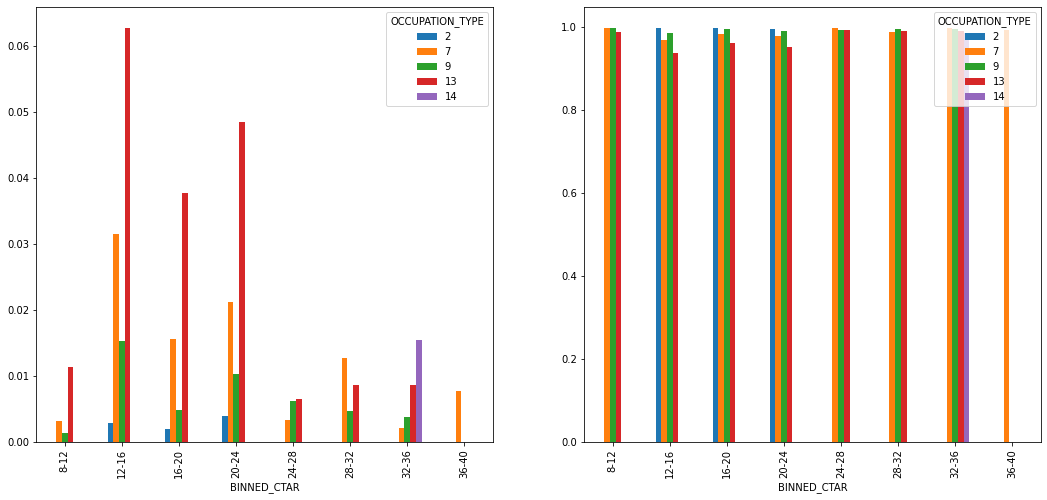

In [0]:
# OCCUPATION_TYPE
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
occ_df = df[(df['OCCUPATION_TYPE']==13)|(df['OCCUPATION_TYPE']==7)|(df['OCCUPATION_TYPE']==9)|(df['OCCUPATION_TYPE']==14)|(df['OCCUPATION_TYPE']==2)][['OCCUPATION_TYPE', 'BINNED_CTAR', 'PREDICTED_TARGET']]
occ_df.groupby('BINNED_CTAR').apply(lambda x: get_ratio_of_risk_labels(x, 'OCCUPATION_TYPE')).plot(kind='bar', figsize=(18,8), ax=ax1)
occ_df.groupby('BINNED_CTAR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'OCCUPATION_TYPE')).plot(kind='bar', figsize=(18,8), ax=ax2)

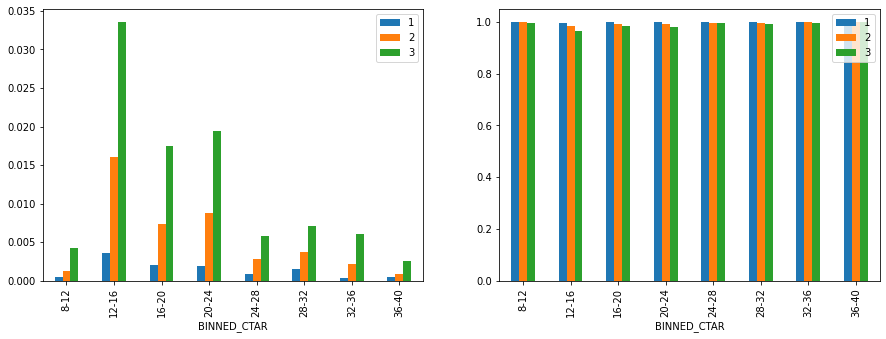

In [0]:
# RATING OF REGION WHERE CLIENT LIVES
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['REGION_RATING_CLIENT', 'BINNED_CTAR', 'PREDICTED_TARGET']].groupby('BINNED_CTAR').apply(lambda x: get_ratio_of_risk_labels(x, 'REGION_RATING_CLIENT')).unstack(1).plot(kind='bar', ax=ax1)
df[['REGION_RATING_CLIENT', 'BINNED_CTAR', 'PREDICTED_TARGET']].groupby('BINNED_CTAR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'REGION_RATING_CLIENT')).unstack(1).plot(kind='bar', ax=ax2)

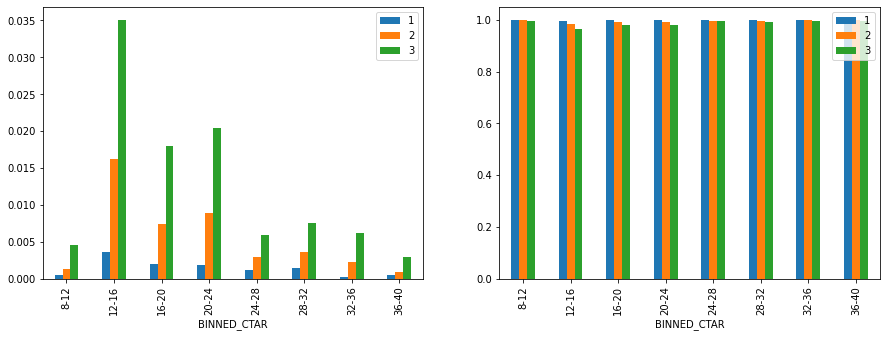

In [0]:
# RATING OF REGION WHERE CLIENT LIVES WITH RESPECT TO CITY
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
df[['REGION_RATING_CLIENT_W_CITY', 'BINNED_CTAR', 'PREDICTED_TARGET']].groupby('BINNED_CTAR').apply(lambda x: get_ratio_of_risk_labels(x, 'REGION_RATING_CLIENT_W_CITY')).unstack(1).plot(kind='bar', ax=ax1)
df[['REGION_RATING_CLIENT_W_CITY', 'BINNED_CTAR', 'PREDICTED_TARGET']].groupby('BINNED_CTAR').apply(lambda x: get_ratio_of_no_risk_labels(x, 'REGION_RATING_CLIENT_W_CITY')).unstack(1).plot(kind='bar', ax=ax2)